In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import import_data

/home/ecford/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ecford/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# load the dataset
dataframe = import_data.import_data('./hackathon_data/hackathon*.dat', index_col_val='date_' , parse_dates='date_', date_format='%Y%m%d')
cols = dataframe.columns.tolist()
cols = cols[-3:] + cols[:-3]
dataframe = dataframe[cols]
print(dataframe.head(5))
dataframe['quantity'].fillna(0, inplace=True)
dataframe.to_csv('./hackathon_data/test_data.dat')

            quantity  on_promotion  promotion_type  store  department    item  \
date_                                                                           
2009-01-02      12.0             0               0    315           2    8598   
2009-01-02      15.0             0               0    315           2   22631   
2009-01-02       9.0             0               0    315           2  102257   
2009-01-02       6.0             0               0    315           2  263929   
2009-01-02       6.0             0               0    315           2  423218   

            unit_price  
date_                   
2009-01-02        5.61  
2009-01-02       11.88  
2009-01-02        9.21  
2009-01-02       16.11  
2009-01-02       14.91  


            quantity  on_promotion  promotion_type  store  department    item  \
date_                                                                           
2009-01-02      12.0             0               0    315           2    8598   
2009-01-02      15.0             0               0    315           2   22631   
2009-01-02       9.0             0               0    315           2  102257   
2009-01-02       6.0             0               0    315           2  263929   
2009-01-02       6.0             0               0    315           2  423218   

            unit_price  
date_                   
2009-01-02        5.61  
2009-01-02       11.88  
2009-01-02        9.21  
2009-01-02       16.11  
2009-01-02       14.91  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1384793 entries, 2009-01-02 to 2012-01-31
Data columns (total 7 columns):
quantity          1384793 non-null float64
on_promotion      1384793 non-null int64
promotion_type    1384793 non-null int64
store

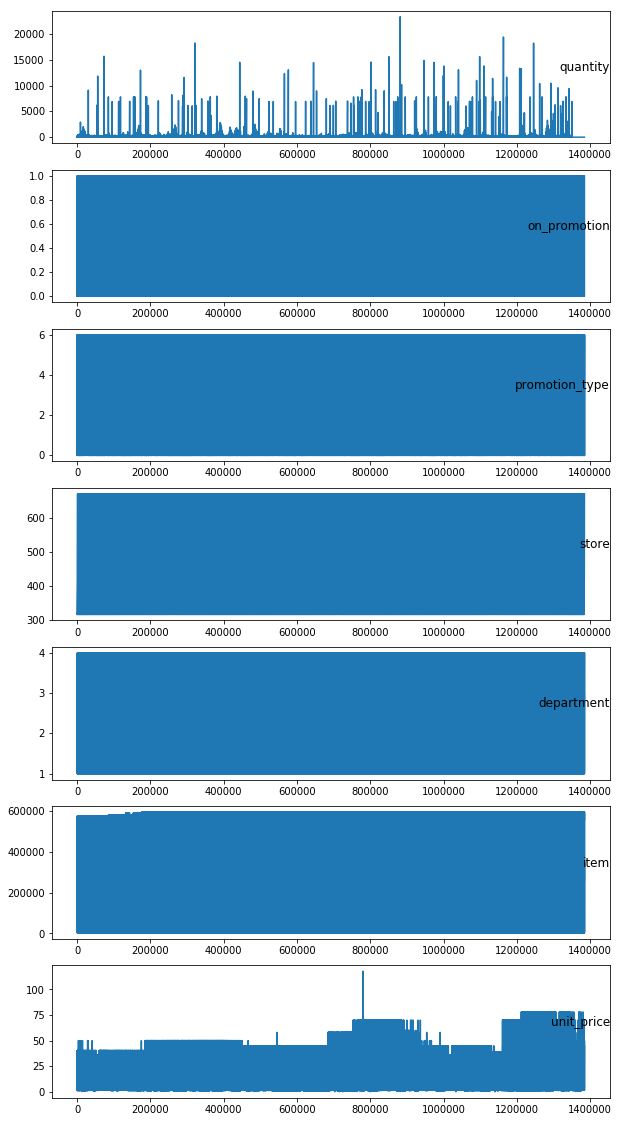

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib as mpl
# load dataset
dataset = read_csv('./hackathon_data/test_data.dat', header=0, index_col=0, parse_dates=['date_'])
print(dataset.head(5))
dataset.info()
values= dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
mpl.rcParams['figure.figsize'] = (10,20)
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# load dataset
dataset = read_csv('./hackathon_data/test_data.dat', header=0, index_col=0)
values = dataset.values
print(values[:,0])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 200
n_out = 100
n_features = 7
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_out)
# drop columns we don't want to predict
for i in range(0, n_out):
    reframed.drop(reframed.columns[[(n_hours*n_features+1), 
                                    (n_hours*n_features+2), 
                                    (n_hours*n_features+3), 
                                    (n_hours*n_features+4), 
                                    (n_hours*n_features+5), 
                                    (n_hours*n_features+6)]],
                  axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

[12. 15.  9. ...  0.  0.  0.]


In [ ]:
# split into train and test sets
values = reframed.values
print(len(values))
print(len(dataset))
n_dataset = len(dataset['2009-01-01':'2012-01-01'])
n_train_days = n_dataset * 2 //3
train = values[:n_train_days, :]
test = values[n_train_days:n_dataset-(n_hours+n_out-1),:]
predict = values[n_dataset-(n_hours+n_out-1):,:n_obs]
print(len(predict))
# print(test)
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:,:n_obs], train[:, -n_out]
test_X, test_y = test[:, :n_obs], test[:, -n_out]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
predict = predict.reshape((predict.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

## Fitting the network:
We chose epochs value of 20 because after experimenting on different values we figured out that the loss doesn't improve very much after the 20th epoch.

The batch_size was also chosen to be the average number of data points per day

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=1074, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# test prediction accuracy
yhat = model.predict(test_X)

In [ ]:
test_X_2 = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_2[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_2[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
wape = sum(abs(inv_y - inv_yhat))/sum(inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test WAPE: %.3f' % wape)

In [ ]:
# prediction
prediction_yhat = model.predict(predict)

In [ ]:
# print(prediction_yhat)
prediction_X= predict.reshape((predict.shape[0], n_hours*n_features))
# invert scaling for forecast
prediction_inv_yhat = concatenate((prediction_yhat, prediction_X[:, -6:]), axis=1)
predicted_column = scaler.inverse_transform(prediction_inv_yhat)
print(predicted_column)
# print(prediction_inv_yhat)


In [ ]:
ret = read_csv('./hackathon_data/hackathon_result.dat')
ret.info()
print(len(ret['quantity']),len(predicted_column))
ret['quantity'] = predicted_column
ret.info()
ret.to_csv('result.dat', index=False)